# AdventureWorks Försäljningsanalys

I denna analys undersöker vi AdventureWorks-databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Vi använder SQL för att hämta data och Python för visualisering och analys

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Makedonien00")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")

connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\iidac\AppData\Local\Temp\ipykernel_27712\1633842440.py:21: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [3]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkter per kategori
Hur många produkter finns i varje kategori?

Tabeller som används:
- Production.ProductCategory
- Production.ProductSubCategory
- Production.Product

Plan:
- JOINA tabellerna
- Räkna DISTINCT produkter per kategori
- Skapa vertikalt stapeldiagram
- Analysera resultatet


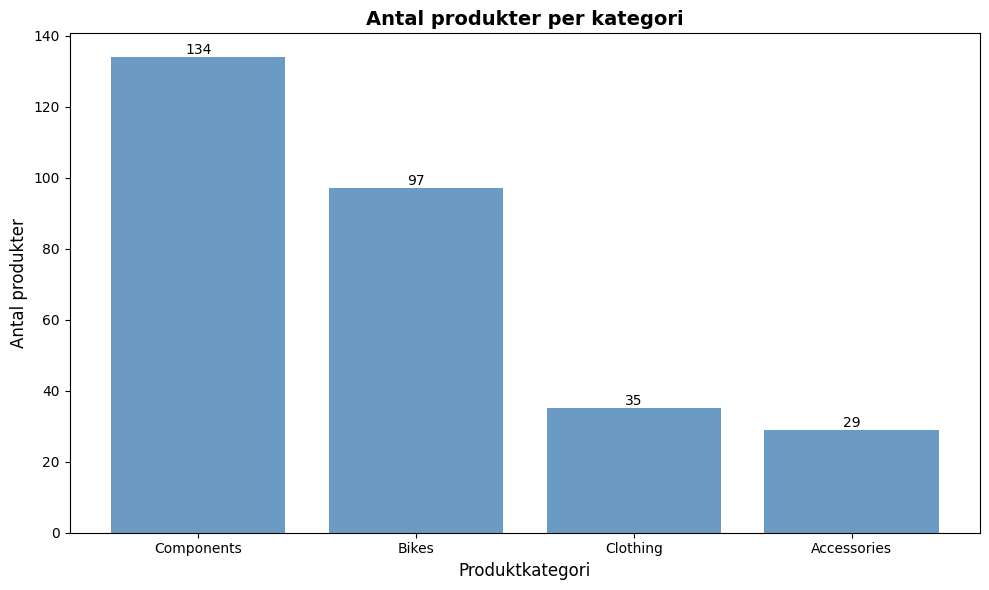

In [4]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubCategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubCategoryID = p.ProductSubCategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)



fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='steelblue', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )
ax.set_xlabel('Produktkategori', fontsize=12)
ax.set_ylabel('Antal produkter', fontsize=12)
ax.set_title('Antal produkter per kategori', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Insikter - Antal produkter per kategori

Components är största kategorin med 134 produkter.
Accessories är minst med 29 produkter.

Detta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar, även att accessories kan vara ett utvecklingsområde.

## Visualisering 2: Försäljning per produktkategori
Vilka produktkategorier genererar mest intäkter?

Tabeller som används:
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail

Plan:
- JOINA tabellerna
-Räkna total försäljning per kategori med SUM
- Skapa horisontellt stapeldiagram
- Analysera resultatet


C:\Users\iidac\AppData\Local\Temp\ipykernel_27712\402955370.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{x:,.0f}' for x in ax.get_xticks()])


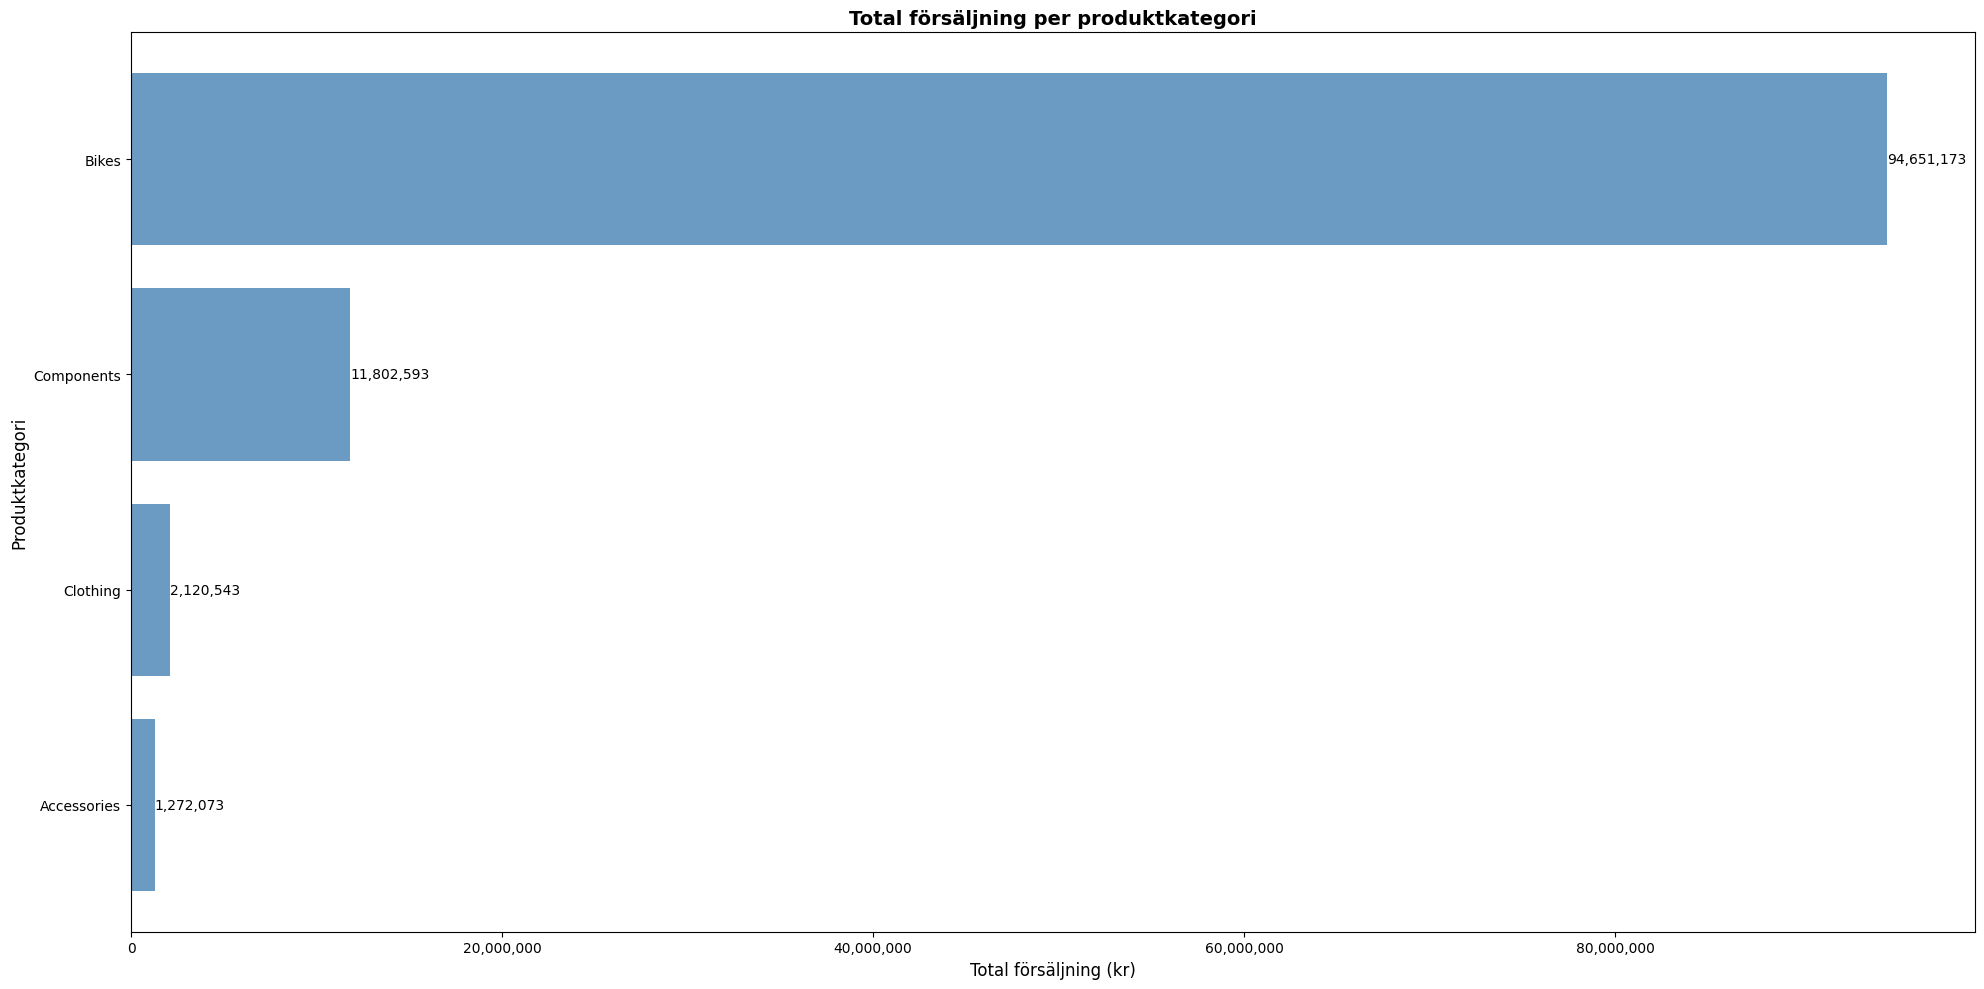

In [5]:
query_vis2 = """

SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubCategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubCategoryID = p.ProductSubCategoryID
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC
""" 

df_vis2 = query_df(query_vis2)
df_vis2.sort_values('TotalSales', inplace=True, ascending=True)

fig, ax = plt.subplots(figsize=(20, 10))

bars = ax.barh(df_vis2['CategoryName'], df_vis2['TotalSales'], color='steelblue', alpha=0.8)
for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f'{width:,.0f}',
        ha='left',
        va='center'
    )
ax.set_ylabel('Produktkategori', fontsize=12)
ax.set_xlabel('Total försäljning (kr)', fontsize=12)
ax.set_title('Total försäljning per produktkategori', fontsize=14, fontweight='bold')

ax.set_xticklabels([f'{x:,.0f}' for x in ax.get_xticks()])


plt.tight_layout()
plt.show() 

### Insikter - Försäljning per produktkategori

Bikes är kategorin med störst total försäljning på 94 651 173kr. Accessories är kategorin med minst total försäljning på 1 272 073kr. 

Detta indikerar på att bikes, som är huvudprodukten, säljer mest. Accessories totala försäljning kan bero på att produkterna har lägre prisnivåer men även en lägre efterfrågan.

## Visualisering 3: Försäljningstrend över tid
Hur har försäljningen utvecklats över tid?

Tabeller som används:
- Sales.SalesOrderHeader

Plan:

C:\Users\iidac\AppData\Local\Temp\ipykernel_27712\3638843028.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()])


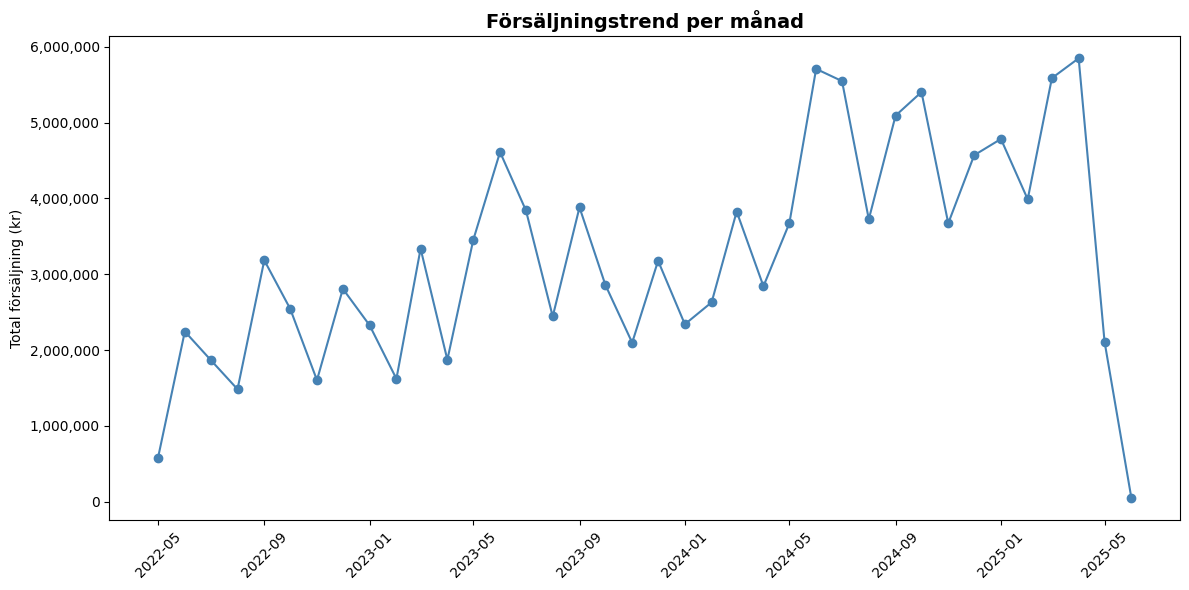

In [17]:
query_vis3 = """

SELECT
    SUM(TotalDue) AS TotalOrderSales,
    YEAR(OrderDate) AS OrderYear,
    MONTH(OrderDate) AS OrderMonth
FROM Sales.SalesOrderHeader
GROUP BY
    YEAR(OrderDate),
    MONTH(OrderDate)
ORDER BY OrderYear , OrderMonth;
"""


df_vis3 = query_df(query_vis3)

df_vis3['OrderMonth'] = pd.to_datetime(df_vis3['OrderYear'].astype(str) + '-' + df_vis3['OrderMonth'].astype(str))

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    df_vis3['OrderMonth'],
    df_vis3['TotalOrderSales'],
    marker='o',
    color='steelblue' 
)

ax.set_title('Försäljningstrend per månad', fontsize=14, fontweight='bold')
ax.set_ylabel('Total försäljning (kr)')

ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()])

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Insikter -Försäljningstrend per månad

Försäljningstrenden har generellt ökat under åren, fram tills våren 2025 där det skedde en rejäl minskning, april 2025 till juni 2025. 
Högsta månaden är april 2025.
Lägsta månaden är juni 2025.

Det verkar inte finnas en tydlig säsongsberoende trend.